Convert a wflow NetCDF output result to the Ugrid NetCDF format that can be used by D-Eco Impact

In [1]:
#load required libraries and prepare logging
import os
import xarray as xr
import xugrid as xu
import logging

logger = logging.getLogger(__name__)

import sys  
sys.path.insert(1, '../library')
from DEcoImpact_conv_func import DEIModel

In [2]:
#configuration
ds_in = r'..\tests\rawdata\wflow_output_example.nc' #input location of file that needs to be converted
ds_out = r'input_DEI_wflow_output.nc'            #output location of file that can be loaded by D-Eco Impact
crs_code = "epsg:4326"                           #coordinate system applicable to file


In [3]:
#Show original file structure
xr_file = xr.open_dataset(ds_in)
print(xr_file)

<xarray.Dataset> Size: 2MB
Dimensions:      (lon: 96, lat: 183, layer: 4, time: 5)
Coordinates:
  * lon          (lon) float64 768B 137.6 137.6 137.6 ... 138.4 138.4 138.4
  * lat          (lat) float64 1kB 34.65 34.65 34.66 34.67 ... 36.15 36.15 36.16
  * layer        (layer) float64 32B 1.0 2.0 3.0 4.0
  * time         (time) datetime64[ns] 40B 2008-09-01 2008-09-02 ... 2008-09-05
Data variables:
    int          (time, lat, lon) float32 351kB ...
    river_width  (time, lat, lon) float32 351kB ...
    q_land       (time, lat, lon) float32 351kB ...
    q_river      (time, lat, lon) float32 351kB ...
    water_depth  (time, lat, lon) float32 351kB ...
    h_land       (time, lat, lon) float32 351kB ...
    precip       (time, lat, lon) float32 351kB ...


In [5]:
#initialize
DEI = DEIModel()
cwd = os.getcwd()
DEI.set_root(root = cwd)

#read Netcdf
region_dict = {"grid": ds_in}
DEI.setup_ugrid(region = region_dict, crs = crs_code)
print(DEI._mesh2d)

#Flow velocity is precalculated as an input variable due to the large calculation time when calculated in D-Eco Impact
# Calculation is "flow velocity (m/s)" = "discharge (m3/s)" / ( "water depth (m)" * "river width (m)" )
DEI._mesh2d["flow_velocity"] = DEI._mesh2d["q_river"] / ( DEI._mesh2d["water_depth"] * DEI._mesh2d["river_width"] )

#export result
DEI.write_mesh(fn_temp = "example_output_data/temporary_file.nc", fn_ecoimpact = "example_output_data/"+ds_out)

print("Done.")

<xarray.Dataset> Size: 4MB
Dimensions:        (time: 5, mesh2d_nFaces: 17568, mesh2d_nNodes: 17848,
                    mesh2d_nEdges: 35415)
Coordinates:
  * time           (time) object 40B 2008-09-01 00:00:00 ... 2008-09-05 00:00:00
    mesh2d_face_x  (mesh2d_nFaces) float64 141kB 137.6 137.6 ... 138.4 138.4
    mesh2d_face_y  (mesh2d_nFaces) float64 141kB 36.16 36.16 ... 34.65 34.65
    mesh2d_node_x  (mesh2d_nNodes) float64 143kB 137.6 137.6 ... 138.4 138.4
    mesh2d_node_y  (mesh2d_nNodes) float64 143kB 36.17 36.17 ... 34.64 34.64
    mesh2d_edge_x  (mesh2d_nEdges) float64 283kB 137.6 137.6 ... 138.4 138.4
    mesh2d_edge_y  (mesh2d_nEdges) float64 283kB 36.17 36.16 ... 34.64 34.64
  * mesh2d_nFaces  (mesh2d_nFaces) int64 141kB 0 1 2 3 ... 17565 17566 17567
  * mesh2d_nEdges  (mesh2d_nEdges) int64 283kB 0 1 2 3 ... 35412 35413 35414
  * mesh2d_nNodes  (mesh2d_nNodes) int64 143kB 0 1 2 3 ... 17845 17846 17847
Data variables:
    int            (time, mesh2d_nFaces) float32 351kB 

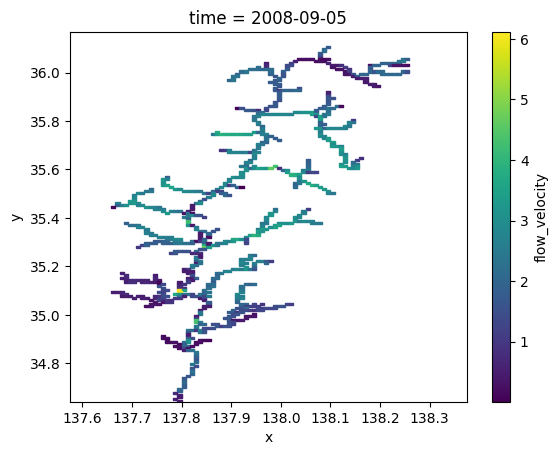

In [7]:
#visualize results
with xu.open_mfdataset("example_output_data/"+ds_out) as result:
    result["flow_velocity"].sel(time= "2008-09-05 00:00:00" ).ugrid.plot()